Подключение гугл диска

In [117]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 3
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  3


Библиотеки

In [40]:
from pandas import read_csv
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Masking, Embedding
from sklearn.preprocessing import MinMaxScaler

Keras SimpleRNN
The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

In [102]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation = activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    # Dropout for regularization
    #model.add(Dropout(0.5))
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
    return model

demo_model = create_RNN(5, 1, (3,1), activation=['relu', 'softmax'])
demo_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 5)                 35        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [67]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]
 
print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[ 7.0511651e-01 -2.4102068e-01 -6.9165230e-04 -6.4506340e-01
   2.2805786e-01]]  wh =  [[-0.45494926 -0.6211134   0.30218267 -0.5489186  -0.12088476]
 [-0.2487898   0.347314   -0.59572035 -0.5894636   0.33930284]
 [-0.6088557  -0.2544146  -0.22082362  0.57665926  0.4280992 ]
 [ 0.19842131 -0.47150114 -0.7106233   0.08266629 -0.4759165 ]
 [-0.5666114   0.4544787   0.00737413  0.10886323 -0.6785978 ]]  bh =  [0. 0. 0. 0. 0.]  wy = [[ 0.24076581]
 [ 0.96648955]
 [ 0.71266794]
 [ 0.3459823 ]
 [-0.84296584]] by =  [0.]


In [69]:
x = np.array([1, 2, 3, 4, 5, 6])

# Reshape the input to the required sample_size x time_steps x features 
x_input = np.reshape(x,(1, 6, 1))
y_pred_model = demo_model.predict(x_input)
 
m = 5
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
h4 = np.dot(x[3], wx) + np.dot(h3,wh) + bh
h5 = np.dot(x[4], wx) + np.dot(h4,wh) + bh
#h6 = np.dot(x[5], wx) + np.dot(h5,wh) + bh
output = np.dot(h5, wy) + by

#print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3) 
print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3, 'h4 = ', h4, 'h5 = ', h5, 'h6 = ', h6)
 
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", output)

h1 =  [[ 7.05116510e-01 -2.41020679e-01 -6.91652298e-04 -6.45063400e-01
   2.28057861e-01]] h2 =  [[ 0.89261088 -0.595737    0.81550317 -1.56400218  0.44103954]] h3 =  [[ 0.80071699 -0.75398644  1.55713559 -1.68500545  1.16829751]] h4 =  [[ 0.69938197 -0.79399851  1.55052829 -1.68950633  1.23533348]] h5 =  [[ 1.42570184 -0.9517058   1.54820277 -2.25224388  1.41588799]] h6 =  [[ 1.62706817 -1.35064623  2.26268123 -3.23123977  1.64693095]]
Prediction from network  [[1.]]
Prediction from our computation  [[-1.44598074]]


In [70]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/TestDataset3.csv' 
train_data, test_data, data = get_train_test(dataset_url)

In [112]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 6
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [118]:
model = create_RNN(hidden_units=5, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
66/66 - 1s - loss: 0.5354 - accuracy: 0.0152
Epoch 2/20
66/66 - 0s - loss: 0.1775 - accuracy: 0.0152
Epoch 3/20
66/66 - 0s - loss: 0.1367 - accuracy: 0.0000e+00
Epoch 4/20
66/66 - 0s - loss: 0.1166 - accuracy: 0.0303
Epoch 5/20
66/66 - 0s - loss: 0.1009 - accuracy: 0.0303
Epoch 6/20
66/66 - 0s - loss: 0.0858 - accuracy: 0.0303
Epoch 7/20
66/66 - 0s - loss: 0.0750 - accuracy: 0.0303
Epoch 8/20
66/66 - 0s - loss: 0.0654 - accuracy: 0.0303
Epoch 9/20
66/66 - 0s - loss: 0.0553 - accuracy: 0.0303
Epoch 10/20
66/66 - 0s - loss: 0.0457 - accuracy: 0.0303
Epoch 11/20
66/66 - 0s - loss: 0.0387 - accuracy: 0.0303
Epoch 12/20
66/66 - 0s - loss: 0.0312 - accuracy: 0.0303
Epoch 13/20
66/66 - 0s - loss: 0.0234 - accuracy: 0.0303
Epoch 14/20
66/66 - 0s - loss: 0.0179 - accuracy: 0.0303
Epoch 15/20
66/66 - 0s - loss: 0.0137 - accuracy: 0.0303
Epoch 16/20
66/66 - 0s - loss: 0.0102 - accuracy: 0.0303
Epoch 17/20
66/66 - 0s - loss: 0.0081 - accuracy: 0.0303
Epoch 18/20
66/66 - 0s - loss: 0.006

In [122]:
# Восстановим в точности ту же модель, включая веса и оптимизатор

Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_37 (SimpleRNN)    (None, 5)                 35        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [123]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = Loading_model.predict(trainX)
test_predict = Loading_model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.073 RMSE
Test RMSE: 0.080 RMSE


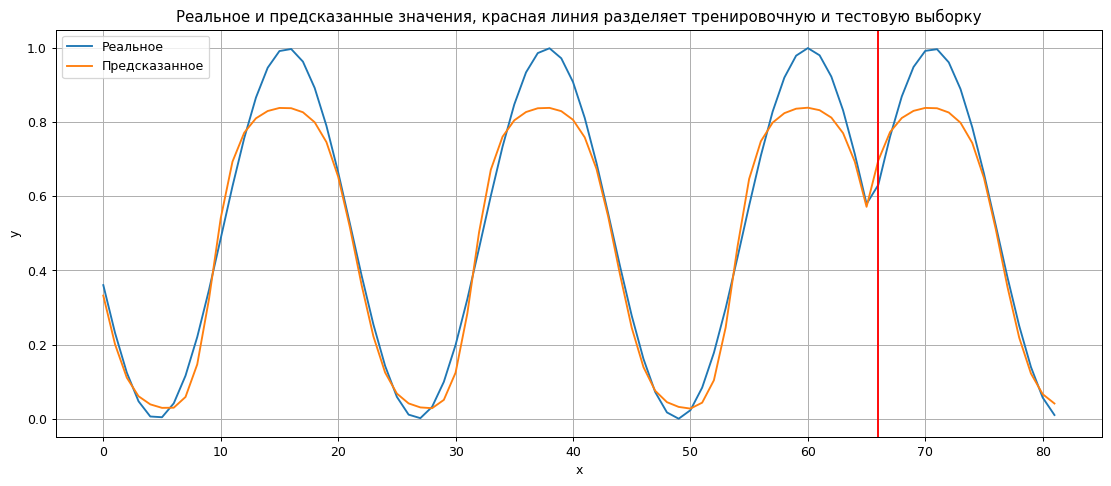

In [124]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(trainY, testY, train_predict, test_predict)